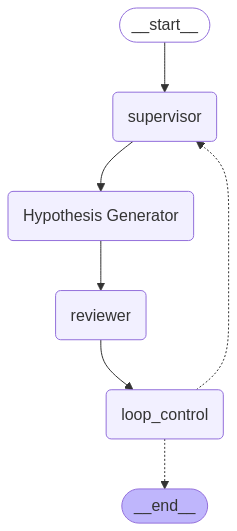

In [9]:
#### Use langchain multiple tools by agent and action, also show config file
###https://medium.com/@astropomeai/advanced-multi-agent-ai-system-implementing-iterative-processing-feedback-loops-and-evaluation-b9cccfc4c9d1
from langchain import OpenAI, LLMMathChain, SerpAPIWrapper
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.tools import BaseTool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
#from langgraph.checkpoint import Checkpointer
from langgraph.checkpoint.memory import MemorySaver
from typing import List, TypedDict, Annotated, Literal
import operator

from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel
from langchain.schema import HumanMessage, AIMessage
import json, os
import requests
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ConversationBufferMemory
import uuid
from typing import Literal, Dict, List
memory = MemorySaver()

API_KEY = ''
from langchain.tools import tool

os.environ['OPENAI_API_KEY']=API_KEY
def create_llm(model_class, model_name, temperature=0.7):
    return model_class(model=model_name, temperature=temperature)

# Initialize LLM models
#claude = create_llm(ChatAnthropic, "claude-3-haiku-20240307")
#gemini = create_llm(ChatGoogleGenerativeAI, "gemini-1.5-flash-latest")
#deepseek = ChatOpenAI(model="deepseek-chat", temperature=0, openai_api_key=Deepseek_key, openai_api_base='https://api.deepseek.com')
openai = create_llm(ChatOpenAI, "gpt-4o")
reviewer = create_llm(ChatOpenAI, "gpt-4o")

from langgraph.graph import END, StateGraph
from typing import List, Tuple

class AgentState(TypedDict):
    focus_areas: List[str]
    research_goal: str
    research_observations: List[str]
    hypotheses_and_proposals: List[Tuple[str, str]]
    hypotheses_and_proposals_with_scores: List[Tuple[str, str, float]]
    ranked_hypotheses: List[Tuple[str, str, float]]
    messages: Annotated[List[HumanMessage], add_messages]
    iteration: int
    expected_result: str
    feedback: str
    agent_outputs: Annotated[List[AIMessage], add_messages]
    evaluation: float
    continue_loop: bool  # Flag to continue the loop

class Node:
    def __init__(self, name: str):
        self.name = name

    def process(self, state: AgentState) -> dict:
        raise NotImplementedError

    def __call__(self, state: AgentState) -> dict:
        result = self.process(state)
        print(f"{self.name}: Processing complete")
        return result


class SupervisorAgent:
    def __init__(self):
        self.name = "Supervisor"

    def __call__(self, state):
        """
        Extract research topic from human input and set expected result.
        """
        if state.get('messages'):
            research_topic = state['messages'][0].content
            state['research_topics'] = [research_topic]
            # Set expected result dynamically based on input topic
            state['expected_result'] = (
                f"Provide an in-depth analysis of the topic: {research_topic}, "
                "including relevant scientific theories, recent studies, and philosophical perspectives."
            )
        else:
            state['research_topics'] = ["Default research topic"]
            state['expected_result'] = "Provide a general analysis of the given research topic."
        return state


class AgentNode(Node):
    def __init__(self, agent_name: str, llm):
        super().__init__(agent_name)
        self.llm = llm

    def process(self, state: AgentState) -> dict:
        task = state['messages'][-1].content
        feedback = state.get('feedback', '')
        if feedback:
            task += f"\nFeedback: {feedback}"
        prompt = f"You are {self.name}. Please perform the following task: {task}"
        response = self.llm(messages=[HumanMessage(role="user", content=prompt)])
        agent_output = AIMessage(role="assistant", content=f"{self.name} response: {response.content}")
        state['agent_outputs'].append(agent_output)
        return {"messages": [agent_output], "agent_outputs": [agent_output]}


   
class HypothesisGenerationAgent:
    def __init__(self, llm):
        self.name = "Hypothesis Generator"
        self.llm = llm

    def __call__(self, state):
        """
        Generate hypotheses based on research topics and previous feedback.
        """
        research_topics = state.get('research_topics', [])
        feedback = state.get('feedback', '')

        # Generate new hypotheses considering feedback
        hypotheses = self.generate_hypotheses(research_topics, feedback)

        # Ensure 'agent_outputs' contains role and content keys
        if 'agent_outputs' not in state:
            state['agent_outputs'] = []

        if hypotheses:  # Only append if hypotheses are not empty
            hypothesis_text = "\n".join(
                [f"Topic: {h['Topic']}\nHypothesis: {h['Hypothesis']}" for h in hypotheses]
            )
            # Add hypothesis output in the correct format
            state['agent_outputs'].append({
                "role": "assistant",
                "content": f"{self.name} generated the following hypotheses:\n{hypothesis_text}"
            })
        else:
            # Add fallback output if no hypotheses are generated
            state['agent_outputs'].append({
                "role": "assistant",
                "content": f"{self.name} did not generate any hypotheses."
            })

        return state

    def generate_hypotheses(self, research_topics, feedback):
        topics_text = "\n".join(research_topics)
        feedback_text = f"\nPrevious Feedback: {feedback}" if feedback else ""

        prompt = (
            f"Research Topics:\n{topics_text}\n\n"
            f"{feedback_text}\n\n"
            """For each research topic, generate a well-structured scientific hypothesis.
             You are an domain expert tasked with formulating a novel and robust hypothesis.  
            
             Search AML cell lines or AML disease often exhibit upregulated pathways with preclinical evidence 
             
             Identify a drug will downregulated key regulators or enzymes for any of the up-regulated pathways  with preclinical evidence.
                               
             The ultimate goal is have a completely novel repurposing the drug for AML
             
             You have conducted a thorough review of relevant literature and developed a logical framework
             for addressing the objective. The articles consulted, along with your analytical reasoning,
             are provided below.
             Goal: {goal}
             {preferences}
             Existing hypothesis (if applicable):
             {source_hypothesis}
             {instructions}
             Literature review and analytical rationale (chronologically ordered, beginning
             with the most recent analysis):
             {articles_with_reasoning}
             Proposed hypothesis (detailed description for domain experts)
            Ensure the hypotheses are testable and based on existing scientific principles.\n\n"""
            "Format:\n- Topic: <topic>\n  Hypothesis: <hypothesis>"
        )

        response = self.llm(prompt)
        response_content = response if isinstance(response, str) else response.content
        return self.parse_hypotheses(response_content)

    def parse_hypotheses(self, content):
        lines = content.splitlines()
        hypotheses = []
        current_topic = None
        for line in lines:
            if line.startswith("- Topic:"):
                current_topic = line.replace("- Topic:", "").strip()
            elif line.startswith("  Hypothesis:") and current_topic:
                hypothesis = line.replace("  Hypothesis:", "").strip()
                hypotheses.append({"Topic": current_topic, "Hypothesis": hypothesis})
        return hypotheses


class ReviewerNode:
    def __init__(self, llm):
        self.name = "Reviewer"
        self.llm = llm

    def __call__(self, state):
        expected_result = state.get('expected_result', '')

        # ✅ Debug print to check if state is being passed
        print(f"\n--- State in ReviewerNode ---\n{state}\n")

        # Collect outputs from agent_outputs
        agent_outputs = state.get('agent_outputs', [])
        if not agent_outputs:
            state['feedback'] = "The agent output is missing."
            return state

        # Extract agent outputs in the correct format
        agent_outputs_text = "\n".join([f"{output.get('role', 'unknown')}: {output.get('content', '')}" for output in agent_outputs])

        # Generate review feedback
        review_prompt = (
            f"Expected result:\n{expected_result}\n\n"
            f"Agent outputs:\n{agent_outputs_text}\n\n"
            "Please compare the expected result with the agent outputs, "
            "and provide feedback and an evaluation score between 0 and 1.\n"
            "Format:\nFeedback: ...\nEvaluation Score: 0.X"
        )

        response = self.llm(review_prompt)

        # Extract content if response is an AIMessage object
        response_content = response.content if hasattr(response, 'content') else str(response)

        feedback, evaluation = self.parse_feedback_and_evaluation(response_content)
        state['feedback'] = feedback
        state['evaluation'] = evaluation
        return state
    def parse_feedback_and_evaluation(self, content):
        """
        Parses the feedback and evaluation from the LLM response.
        """
        lines = content.splitlines()
        feedback = ''
        evaluation = 0.0
        for line in lines:
            if line.startswith("Feedback:"):
                feedback = line.replace("Feedback:", "").strip()
            elif line.startswith("Evaluation Score:"):
                score_str = line.replace("Evaluation Score:", "").strip()
                try:
                    evaluation = float(score_str)
                except ValueError:
                    evaluation = 0.0
        return feedback, evaluation

class ReviewerNode:
    
    def __init__(self, llm):
        self.name = "Reviewer"
        self.llm = llm

    def __call__(self, state):
        expected_result = state.get('expected_result', '')

        # Collect outputs from agent_outputs
        agent_outputs = state.get('agent_outputs', [])
        if not agent_outputs:
            state['feedback'] = "The agent output is missing."
            return state

        # Extract agent outputs in the correct format
        agent_outputs_text = ""
        for output in agent_outputs:
            if hasattr(output, 'role') and hasattr(output, 'content'):
                # If output is an AIMessage object
                agent_outputs_text += f"{output.role}: {output.content}\n"
            elif isinstance(output, dict):
                # If output is a dictionary
                agent_outputs_text += f"{output.get('role', 'unknown')}: {output.get('content', '')}\n"
            else:
                # Handle unknown output format
                agent_outputs_text += f"Unknown format: {str(output)}\n"

        # Generate review feedback
        review_prompt = (
            f"Expected result:\n{expected_result}\n\n"
            f"Agent outputs:\n{agent_outputs_text}\n\n"
            "Please compare the expected result with the agent outputs, "
            "and provide feedback and an evaluation score between 0 and 1.\n"
            "Format:\nFeedback: ...\nEvaluation Score: 0.X"
        )

        response = self.llm(review_prompt)

        # Extract content if response is an AIMessage object
        response_content = response.content if hasattr(response, 'content') else str(response)

        feedback, evaluation = self.parse_feedback_and_evaluation(response_content)
        state['feedback'] = feedback
        state['evaluation'] = evaluation
        return state

    
    

    
    def parse_feedback_and_evaluation(self, content):
        """
        Parses the feedback and evaluation from the LLM response.
        """
        lines = content.splitlines()
        feedback = ''
        evaluation = 0.0
        for line in lines:
            if line.startswith("Feedback:"):
                feedback = line.replace("Feedback:", "").strip()
            elif line.startswith("Evaluation Score:"):
                score_str = line.replace("Evaluation Score:", "").strip()
                try:
                    evaluation = float(score_str)
                except ValueError:
                    evaluation = 0.0
        return feedback, evaluation




class LoopControlNode:
    def __init__(self, max_iterations):
        self.max_iterations = max_iterations

    def __call__(self, state):
        # Increment iteration count
        state['iteration'] += 1

        # Print the output of each iteration
        print(f"\n===== Iteration {state['iteration']} =====")
        print("Expected Result:", state.get('expected_result', 'N/A'))

        # Handle different output formats
        agent_outputs = state.get('agent_outputs', [])
        if agent_outputs:
            for output in agent_outputs:
                if hasattr(output, 'role') and hasattr(output, 'content'):
                    # If output is an AIMessage object
                    print(f"Agent Output from {output.role}: {output.content}")
                elif isinstance(output, dict):
                    # If output is a dictionary
                    print(f"Agent Output from {output.get('agent_name', 'Unknown Agent')}: {output.get('output', '')}")
                else:
                    # Unknown format
                    print(f"Unknown output format: {output}")
        else:
            print("No agent outputs yet.")

        # Print feedback and evaluation
        print("Feedback:", state.get('feedback', 'No feedback'))
        print("Evaluation Score:", state.get('evaluation', 0.0))
        print("===================================\n")

        # Continue loop until reaching the maximum number of iterations
        if state['iteration'] < self.max_iterations:
            state['continue_loop'] = True
        else:
            state['continue_loop'] = False
        return state


class AgentNode:
    def __init__(self, name, llm):
        self.name = name
        self.llm = llm

    def __call__(self, state):
        task = state.get('task', 'No task provided.')
        response = self.llm(f"{self.name} responding to: {task}")
        state[f"{self.name}_output"] = response
        return state



# Initial state with iteration count
initial_state = AgentState(
    messages=[HumanMessage(role="user", content=" Suggest an existing drug that could be repurposed for acute myeloid leukemia (AML)treatment The drug should inhibit the proliferation of AML cell lines")], 
    iteration=0,
    expected_result="Criteria for a strong hypothesis for a drug treatment for AML",
    feedback="",
    agent_outputs=[],
    evaluation=0.0,
    continue_loop=True
)

# Simulate a workflow step for testing
hypothesis_agent = HypothesisGenerationAgent(llm=openai)  # Replace mock_llm with your actual LLM
reviewer = ReviewerNode(llm=openai)

# Pass state through agents
state = hypothesis_agent(initial_state)
state = reviewer(state)


builder = StateGraph(AgentState)

nodes = {
   # "supervisor": SupervisorNode(),
    "supervisor": SupervisorAgent(),
    "Hypothesis Generator":HypothesisGenerationAgent(openai),
   # "agent1": AgentNode("Agent1 (Claude)", openai),
   # "agent2": AgentNode("Agent2 (Gemini)", openai),
   # "agent3": AgentNode("Agent3 (GPT-4)", openai),
    "reviewer": ReviewerNode(openai),
    "loop_control": LoopControlNode(max_iterations=5)
}

for name, node in nodes.items():
    builder.add_node(name, node)



# Define the flow
builder.add_edge(START, "supervisor")

# Edges from Supervisor to Agents
builder.add_edge("supervisor", "Hypothesis Generator")
#builder.add_edge("supervisor", "agent2")
#builder.add_edge("supervisor", "agent3")

# Edges from Agents to Reviewer
builder.add_edge("Hypothesis Generator", "reviewer")
#builder.add_edge("agent2", "reviewer")
#builder.add_edge("agent3", "reviewer")

# Edge from Reviewer to Loop Control Node
builder.add_edge("reviewer", "loop_control")

# Conditionally decide the next node from Loop Control Node
def next_node(state: AgentState) -> Literal["supervisor", END]:
    if state['continue_loop']:
        return "supervisor"
    else:
        return END

builder.add_conditional_edges("loop_control", next_node)

# Compile the graph
graph = builder.compile()

from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#SupervisorNode.invoke(initiate_state)

In [4]:
# Debug print after hypothesis generation
print("Agent Outputs in State Before Reviewer:")
for output in state['agent_outputs']:
    print(output) 


Agent Outputs in State Before Reviewer:
{'role': 'assistant', 'content': 'Hypothesis Generator did not generate any hypotheses.'}


In [5]:
# Invoke the graph with recursion limit
final_state = graph.invoke(initial_state, {"recursion_limit": 150})


# Print final outputs while handling both AIMessage objects and dictionary outputs
print("Final Agent Outputs:")
for output in final_state['agent_outputs']:
    if hasattr(output, 'role') and hasattr(output, 'content'):
        # Handle AIMessage objects
        print(f"{output.role}:\n{output.content}\n")
    elif isinstance(output, dict):
        # Handle dictionary-style outputs
        print(f"{output.get('agent_name', 'Unknown Agent')}:\n{output.get('output', '')}\n")
    else:
        # Handle unknown output formats
        print(f"Unknown output format: {output}")



===== Iteration 1 =====
Expected Result: Provide an in-depth analysis of the topic:  Suggest an existing drug that could be repurposed for acute myeloid leukemia (AML)treatment The drug should inhibit the proliferation of AML cell lines, including relevant scientific theories, recent studies, and philosophical perspectives.
Unknown output format: content='Hypothesis Generator did not generate any hypotheses.' additional_kwargs={} response_metadata={} id='1db90a4f-5cb2-4bc0-a7c4-d62be302a7b2'
Unknown output format: content='Hypothesis Generator generated the following hypotheses:\nTopic: Targeting the FLT3 Pathway in AML\nHypothesis: Inhibition of the FLT3 receptor tyrosine kinase using the drug midostaurin will lead to a significant decrease in the proliferation of AML cells harboring FLT3-ITD mutations, due to its ability to downregulate the hyperactivated FLT3 signaling pathway, thereby reducing downstream activation of STAT5 and MAPK pathways. This effect will be more pronounced in

In [6]:
# Normalize output to standard dictionary format with 'role' and 'content' keys
def normalize_output(output):
    if hasattr(output, 'role') and hasattr(output, 'content'):
        return {"role": output.role, "content": output.content}
    elif isinstance(output, dict):
        return {"role": output.get('role', 'unknown'), "content": output.get('content', '')}
    elif hasattr(output, 'content'):  # Custom object handling
        return {"role": "assistant", "content": output.content}
    else:
        return {"role": "unknown", "content": str(output)}


# Print final outputs after normalizing the output format
print("Final Agent Outputs:")
for output in final_state['agent_outputs']:
    normalized = normalize_output(output)
    print(f"{normalized['role']}:\n{normalized['content']}\n")


Final Agent Outputs:
assistant:
Hypothesis Generator did not generate any hypotheses.

assistant:
Hypothesis Generator generated the following hypotheses:
Topic: Targeting the FLT3 Pathway in AML
Hypothesis: Inhibition of the FLT3 receptor tyrosine kinase using the drug midostaurin will lead to a significant decrease in the proliferation of AML cells harboring FLT3-ITD mutations, due to its ability to downregulate the hyperactivated FLT3 signaling pathway, thereby reducing downstream activation of STAT5 and MAPK pathways. This effect will be more pronounced in cell lines with higher expression levels of FLT3-ITD, supporting the potential repurposing of midostaurin as a targeted therapy for FLT3-ITD-positive AML.
Topic: Repurposing MEK Inhibitors for AML
Hypothesis: The MEK1/2 inhibitor trametinib will effectively reduce the survival and proliferation of AML cells exhibiting hyperactivation of the MAPK/ERK pathway, commonly seen in AML patients with RAS mutations. By downregulating the 

In [7]:
# Function to invoke the graph and print results at each iteration
def run_graph(graph, initial_state, max_iterations=15):
    # Start invoking the graph
    state = initial_state

    for iteration in range(max_iterations):
        print(f"\n🔄===== Iteration {iteration + 1} =====\n")
        
        # Run the graph for the current state
        state = graph.invoke(state, {"recursion_limit": 15})

        # Print Expected Result
        print(f"Expected Result:\n{state.get('expected_result', 'No expected result provided.')}\n")

        # Print Generated Hypotheses
        hypotheses = state.get('hypotheses', [])
        if hypotheses:
            print("Generated Hypotheses:")
            for hypothesis in hypotheses:
                print(f"- Topic: {hypothesis['Topic']}")
                print(f"  Hypothesis: {hypothesis['Hypothesis']}\n")
        else:
            print("No hypotheses generated in this iteration.\n")

        # Print Agent Outputs
        agent_outputs = state.get('agent_outputs', [])
        if agent_outputs:
            print("Agent Outputs:")
            for output in agent_outputs:
                print(f"{output['agent_name']}:\n{output['output']}\n")
        else:
            print("No agent outputs yet.\n")

        # Print Feedback and Evaluation Score
        print(f"Feedback: {state.get('feedback', 'No feedback')}")
        print(f"Evaluation Score: {state.get('evaluation', 0.0)}\n")
        
        # Check if loop should continue
        if not state.get('continue_loop', False):
            print("\n✅ Workflow completed. No further iterations required.\n")
            break

    # Print final results after loop ends
    print("\n🎯 ===== Final Results After All Iterations =====\n")
    print(f"Total Iterations Run: {state['iteration']}")
    print(f"Final Feedback: {state.get('feedback', 'No feedback')}")
    print(f"Final Evaluation Score: {state.get('evaluation', 0.0)}")

    final_hypotheses = state.get('hypotheses', [])
    if final_hypotheses:
        print("\nFinal Hypotheses:")
        for hypothesis in final_hypotheses:
            print(f"- Topic: {hypothesis['Topic']}")
            print(f"  Hypothesis: {hypothesis['Hypothesis']}\n")


In [8]:
import json

# Helper function to normalize outputs
def normalize_output(output):
    if hasattr(output, 'role') and hasattr(output, 'content'):
        return {"role": output.role, "content": output.content}
    elif isinstance(output, dict):
        return {"role": output.get('role', 'unknown'), "content": output.get('content', '')}
    elif hasattr(output, 'content'):  # Handle custom output objects
        return {"role": "assistant", "content": output.content}
    else:
        return {"role": "unknown", "content": str(output)}

# Save results to a text file
def save_results_to_text(final_state, filename="final_results.txt"):
    with open(filename, "w") as file:
        file.write("🎯 ===== Final Results After All Iterations =====\n")
        file.write(f"Total Iterations Run: {final_state['iteration']}\n")
        file.write(f"Final Feedback: {final_state.get('feedback', 'No feedback')}\n")
        file.write(f"Final Evaluation Score: {final_state.get('evaluation', 0.0)}\n\n")

        final_hypotheses = final_state.get('hypotheses', [])
        if final_hypotheses:
            file.write("Final Hypotheses:\n")
            for hypothesis in final_hypotheses:
                file.write(f"- Topic: {hypothesis['Topic']}\n")
                file.write(f"  Hypothesis: {hypothesis['Hypothesis']}\n\n")

# Save results to a JSON file
def save_results_to_json(final_state, filename="final_results.json"):
    with open(filename, "w") as json_file:
        json.dump(final_state, json_file, indent=4)

# Updated run_graph function with saving feature
def run_graph(graph, initial_state, max_iterations=15):
    state = initial_state

    for iteration in range(max_iterations):
        print(f"\n🔄===== Iteration {iteration + 1} =====\n")
        
        state = graph.invoke(state, {"recursion_limit": 15})

        # Print Expected Result
        print(f"Expected Result:\n{state.get('expected_result', 'No expected result provided.')}\n")

        # Print Generated Hypotheses
        hypotheses = state.get('hypotheses', [])
        if hypotheses:
            print("Generated Hypotheses:")
            for hypothesis in hypotheses:
                print(f"- Topic: {hypothesis['Topic']}")
                print(f"  Hypothesis: {hypothesis['Hypothesis']}\n")
        else:
            print("No hypotheses generated in this iteration.\n")

        # Print Agent Outputs using normalized output format
        agent_outputs = state.get('agent_outputs', [])
        if agent_outputs:
            print("Agent Outputs:")
            for output in agent_outputs:
                normalized = normalize_output(output)
                print(f"{normalized['role']}:\n{normalized['content']}\n")
        else:
            print("No agent outputs yet.\n")

        # Print Feedback and Evaluation Score
        print(f"Feedback: {state.get('feedback', 'No feedback')}")
        print(f"Evaluation Score: {state.get('evaluation', 0.0)}\n")
        
        if not state.get('continue_loop', False):
            print("\n✅ Workflow completed. No further iterations required.\n")
            break

    # Save results after completion
    save_results_to_text(state, "final_results.txt")
    save_results_to_json(state, "final_results.json")

    # Print final results
    print("\n🎯 ===== Final Results After All Iterations =====\n")
    print(f"Total Iterations Run: {state['iteration']}")
    print(f"Final Feedback: {state.get('feedback', 'No feedback')}")
    print(f"Final Evaluation Score: {state.get('evaluation', 0.0)}")

    final_hypotheses = state.get('hypotheses', [])
    if final_hypotheses:
        print("\nFinal Hypotheses:")
        for hypothesis in final_hypotheses:
            print(f"- Topic: {hypothesis['Topic']}")
            print(f"  Hypothesis: {hypothesis['Hypothesis']}\n")

    print("\n📁 Results have been saved to 'final_results.txt' and 'final_results.json'.")


In [13]:
# Run the graph and print out each iteration
run_graph(graph, initial_state, max_iterations=15)



🔄===== Iteration 1 =====


===== Iteration 1 =====
Expected Result: Provide an in-depth analysis of the topic:  Suggest an existing drug that could be repurposed for acute myeloid leukemia (AML)treatment The drug should inhibit the proliferation of AML cell lines, including relevant scientific theories, recent studies, and philosophical perspectives.
Unknown output format: content='Hypothesis Generator did not generate any hypotheses.' additional_kwargs={} response_metadata={} id='fc748f05-2c3a-434f-86f7-cf555c4df35a'
Unknown output format: content='Hypothesis Generator did not generate any hypotheses.' additional_kwargs={} response_metadata={} id='6509301b-2473-448e-8e73-77c522d3d853'
Unknown output format: content='Hypothesis Generator did not generate any hypotheses.' additional_kwargs={} response_metadata={} id='2d708640-ad91-48ca-b7ce-eaec9e616eb5'
Feedback: The agent outputs do not align with the expected result. The task was to provide an in-depth analysis of a potential drug t

GraphRecursionError: Recursion limit of 15 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [28]:
final_hypotheses

NameError: name 'final_hypotheses' is not defined